In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_score
import metrics
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from progressbar import ProgressBar
import data_grab
from time import time
from sklearn.externals import joblib
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
def contest_metric(numpy_array_predictions, numpy_array_actual_values):
    return metrics.weighted_rmsle(numpy_array_predictions, numpy_array_actual_values,
            weights=metrics.KEEPING_IT_CLEAN_WEIGHTS)

In [3]:
def contest_scoring(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
    s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
    s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    results = np.dstack((s1, s2, s3))
    score = contest_metric(np.round(results[0]), np.array(y_test))
    print("Contest score of {}".format(score))
    return score

In [4]:
from sklearn.metrics import accuracy_score

def raw_scoring(p1, p2, p3, ytrue):
    '''since cross_val_score doesn't allow you to round the results beforehand. also for pymc3 and other non-sklearn models'''
    score1 = accuracy_score(ytrue['score_lvl_1'], np.clip(np.round(p1), 0, np.inf))
    print("Level 1 accuracy score of {}".format(score1))
    score2 = accuracy_score(ytrue['score_lvl_2'],np.clip(np.round(p2), 0, np.inf))
    print("Level 2 accuracy score of {}".format(score2))
    score3 = accuracy_score(ytrue['score_lvl_3'], np.clip(np.round(p3), 0, np.inf))
    print("Level 3 accuracy score of {}".format(score3))
    
    results = np.dstack((p1, p2, p3))[0]
    rounded = np.clip(np.round(results), 0, np.inf)
    score = contest_metric(rounded, np.array(ytrue))
    print("Contest score of {}".format(score))
    
    compare = pd.concat([pd.DataFrame(np.concatenate((results, rounded), axis=1)), ytrue.reset_index(drop=True)], axis=1)
    compare.columns = ['pred1','pred2','pred3','round1','round2','round3','true1','true2','true3']
    compare['offset1'] = compare.round1-compare.true1
    compare['offset2'] = compare.round2-compare.true2
    compare['offset3'] = compare.round3-compare.true3
        
    return score1, score2, score3, score, compare.head(10)

    
def raw_fit(X, y, pipeline):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
    
    p1 = pipeline.fit(xtrain, ytrain['score_lvl_1']).predict(xtest)
    p2 = pipeline.fit(xtrain, ytrain['score_lvl_2']).predict(xtest)
    p3 = pipeline.fit(xtrain, ytrain['score_lvl_3']).predict(xtest)
        
    return p1, p2, p3, ytest

In [5]:
def extract_features(df):
    features = df.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1)
    response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.int8)
    
    return features, response

In [211]:
combo = pd.read_pickle('pickle_jar/pre-pivot_all_review_combo_365')
# df = pd.read_pickle('pickle_jar/pre-pivot_365')
# df = pd.read_pickle('pickle_jar/pre-pivot_all_non_review')
df = pd.read_pickle('pickle_jar/post-pivot_non_review_data_365')

In [212]:
combo = combo.sort(['inspection_id', 'enumerated_review_delta']).reset_index(drop=True)
df = df.reset_index().sort('inspection_id')

## convert train dataframe to 365 days and prepare for pivot

In [251]:
df = data_grab.get_selects('train')

In [252]:
# not getting rid of everything. not getting rid of ancient reviews if they correspond with an ancient inspection.
# just getting rid of ancient reviews in relation to a specific inspection
df = df[df.review_delta <= 365]

In [253]:
# making a column that enumerates the sorted review delta.
# removes any nans (usually marked as such because the reviews happend after an inspection date) beforehand.
# this can completely remove a restaurant if it has no reviews left after nan drop. might add back in later
df = df.sort('review_delta')
df2 = df.dropna(subset=['review_delta']).groupby('inspection_id').cumcount()

In [254]:
# df3 = pd.concat([df.dropna(subset=['review_delta']), df2], axis=1)
df = pd.concat([df.dropna(subset=['review_delta']), df2], axis=1)

In [255]:
df = df.rename(columns={0:'enumerated_review_delta'})
del df2

In [28]:
# add back in the restaurants that were completely removed because none of their reviews were
# not a significant loss in the number of restaurants. going to just leave it out for now
# mask = list(set(df.restaurant_id) - set(df3.restaurant_id))
# pd.concat([df[df.restaurant_id.isin(mask)], df3])

In [57]:
df.shape

(500936, 137)

In [14]:
just_review_data = df[[ 
 'inspection_id',
 'enumerated_review_delta',
#  'review_id',
 'review_delta', 
#  'review_date', 
 'review_stars',
 'review_text',
#  'user_id',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
#  'user_fans',
 'user_review_count',
#  'user_votes_cool',
#  'user_votes_funny',
#  'user_votes_useful',
 'user_yelping_since_delta',
#  'review_year',
#  'review_month',
#  'review_day',
#  'review_dayofweek',
#  'review_quarter',
#  'review_dayofyear',
 'user_ever_elite',
 ]]

In [7]:
df.drop([ 'review_delta',
 'review_stars',
 'review_text',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
 'user_fans',
 'user_review_count',
 'user_votes_cool',
 'user_votes_funny',
 'user_votes_useful',
 'user_yelping_since_delta',
 'user_ever_elite'], axis=1, inplace=True)
df.drop(['review_date',
 'review_id',
 'user_id',
 'user_compliments_cool',
 'user_compliments_cute',
 'user_compliments_funny',
 'user_compliments_hot',
 'user_compliments_list',
 'user_compliments_more',
 'user_compliments_note',
 'user_compliments_photos',
 'user_compliments_plain',
 'user_compliments_profile',
 'user_compliments_writer',
 'user_name', 'review_year',
 'review_month',
 'review_day',
 'review_dayofweek',
 'review_quarter',
 'review_dayofyear','user_most_recent_elite_year_delta',], axis=1, inplace=True)
df.drop('enumerated_review_delta', axis=1, inplace=True)

In [8]:
g = df.groupby('inspection_id').max()

In [11]:
g.to_pickle('pickle_jar/post-pivot_non_review_data_365')

In [30]:
df.to_pickle('pickle_jar/pre-pivot_all_non_review')

In [168]:
# this removes all the nans left. review stars as nans because reviews and tips combined and tips didnt give a star rating
# planning to treat this as a categorical variable later so making it zero shouldnt affect anything
just_review_data.review_stars = just_review_data.review_stars.fillna(0)

In [10]:
just_review_data.to_pickle('pickle_jar/pre-pivot_365')

## combine sentiment and similarity with pre-pivot 365 review related data into one dataframe for pivoting

In [14]:
# sentiment = pd.read_pickle('pickle_jar/review_text_sentiment_pivot')
# similarity = pd.read_pickle('pickle_jar/similarity_vectors_pivot')

In [132]:
sentiment = sentiment[['inspection_id', 'enumerated_review_delta', 'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']]

In [137]:
similarity.drop(['review_delta', 'review_stars', 'review_text', 'review_votes_cool', 'review_votes_funny',
                 'review_votes_useful', 'user_average_stars', 'user_fans', 'user_review_count', 'user_votes_cool', 
                 'user_votes_funny', 'user_votes_useful', 'user_yelping_since_delta', 'user_ever_elite',
                 'preprocessed_review_text'], axis=1, inplace=True)

In [159]:
combo = pd.merge(sentiment, similarity, on=['inspection_id', 'enumerated_review_delta'])

In [170]:
just_review_data.drop('review_text', axis=1, inplace=True)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [173]:
combo = pd.merge(combo, just_review_data, on=['inspection_id', 'enumerated_review_delta'])

In [174]:
combo.to_pickle('pickle_jar/pre-pivot_all_review_combo_365')

In [102]:
# sim_length = lambda x: len(np.where(x > 0.7)[0])
def sim_length(x):
    try:
        return len(np.where(x > 0.7)[0])
    except:
        return x

topics = ['manager', 'supervisor', 'training', 'safety', 'disease', 'ill', 'sick', 'poisoning', 'hygiene', 'raw', 'undercooked', 'cold', 'clean', 'sanitary', 'wash', 'jaundice', 'yellow', 'hazard', 'inspection', 'violation', 'gloves', 'hairnet', 'nails', 'jewelry', 'sneeze', 'cough', 'runny', 'illegal', 'rotten', 'dirty', 'mouse', 'cockroach', 'contaminated', 'gross', 'disgusting', 'stink', 'old', 'parasite', 'reheat', 'frozen', 'broken', 'drip', 'bathroom', 'toilet', 'leak', 'trash', 'dark', 'lights', 'dust', 'puddle', 'pesticide', 'bugs', 'mold', ]
# topics = ['manager', 'supervisor', 'training', 'safety', 'disease', 'ill', 'sick', 'poisoning', 'poison', 'hygiene', 'raw', 'undercooked', 'cold', 'clean', 'sanitary', 'wash', 'jaundice', 'yellow', 'hazard', 'inspection', 'violation', 'gloves', 'hairnet', 'nails', 'jewelry', 'sneeze', 'cough', 'runny', 'illegal', 'rotten', 'dirty', 'mouse', 'cockroach', 'contaminated', 'gross', 'disgusting', 'stink', 'old', 'parasite', 'bacteria', 'reheat', 'frozen', 'broken', 'drip', 'bathroom', 'toilet', 'leak', 'trash', 'dark', 'lights', 'dust', 'puddle', 'pesticide', 'bugs', 'mold']
pbar = ProgressBar(maxval=len(topics)).start()
for index, i in enumerate(topics):
    combo[i] = combo[i].apply(sim_length)
    pbar.update(index)
pbar.finish()

# combo.nails.apply(sim_length).value_counts()
# combo[['inspection_id', 'enumerated_review_delta', 'polarity', 'subjectivity']][combo.nails.apply(sim_length) == 1]
# df[(df.inspection_id == 28790) & (df.enumerated_review_delta == 7)].review_text.tolist()

100% (53 of 53) |#########################| Elapsed Time: 0:04:35 Time: 0:04:35


## trustworthiness index

In [213]:
def log_it(x):
#     second_min = x[x != x.min()].min()
#     x.replace(x.min(), second_min/2, inplace=True)
#     return np.log(x)
    x = x + 1
    return np.log(x)

norm = Normalizer()

In [214]:
# making trustworthiness feature
trust = combo[['inspection_id', 'enumerated_review_delta', 'subjectivity',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
 'user_review_count',
 'user_yelping_since_delta',
 'user_ever_elite']]

In [215]:
trust['objectivity'] = 1 - trust.subjectivity
trust.drop('subjectivity', axis=1, inplace=True)

# trust['review_votes']  = log_it(trust.review_votes_useful)*3 + log_it(trust.review_votes_funny)*2 + log_it(trust.review_votes_cool)
trust['review_votes'] = log_it(trust.review_votes_useful*3 + trust.review_votes_funny*2 + trust.review_votes_cool)
# trust['review_votes'] = log_it(trust.review_votes_useful) + log_it(trust.review_votes_funny) + log_it(trust.review_votes_cool)
trust.drop(['review_votes_cool', 'review_votes_funny', 'review_votes_useful'], axis=1, inplace=True)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [197]:
sns.distplot(trust.normalized_history)

AttributeError: 'DataFrame' object has no attribute 'user_history'

In [205]:
trust['user_activity_level'] = trust.user_review_count / trust.user_yelping_since_delta #+ trust.user_ever_elite
trust['normalized_history'] = trust.user_yelping_since_delta / trust.user_yelping_since_delta.max()
trust['normalized_review_count'] = trust.user_review_count / trust.user_review_count.max()
trust.sort('user_activity_level')

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,inspection_id,enumerated_review_delta,user_average_stars,user_review_count,user_yelping_since_delta,user_ever_elite,objectivity,review_votes,user_activity_level,normalized_history,normalized_review_count
59369,4085,2,5.00,0,60,False,0.653432,1.386294,0.000000,0.016380,0.000000
252665,17129,1,5.00,1,2910,False,0.622879,0.000000,0.125372,0.794431,0.000212
437409,29561,29,1.00,1,2650,False,0.533757,1.386294,0.126860,0.723451,0.000212
404462,27324,1,5.00,1,2579,False,0.583333,0.693147,0.127299,0.704068,0.000212
338538,22866,36,5.00,1,2553,False,0.370000,0.000000,0.127463,0.696970,0.000212
18394,1315,24,5.00,1,2553,False,0.370000,0.000000,0.127463,0.696970,0.000212
422600,28524,1,1.00,1,2448,False,0.576190,1.386294,0.128149,0.668305,0.000212
243378,16473,3,1.00,1,2448,False,0.576190,1.386294,0.128149,0.668305,0.000212
455854,30777,13,1.00,1,2448,False,0.576190,1.386294,0.128149,0.668305,0.000212
131720,8852,5,5.00,1,2410,False,0.544048,0.000000,0.128406,0.657931,0.000212


In [202]:
df.sort('user_yelping_since_delta')[['user_yelping_since_delta', 'review_date', 'inspection_date']]

,user_yelping_since_delta,review_date,inspection_date
1744165,-1688,2009-01-17,2009-03-30
1747861,-1688,2009-01-17,2009-09-15
1746937,-1688,2009-01-17,2009-12-21
1752789,-1688,2009-01-17,2009-12-09
1746013,-1688,2009-01-17,2009-08-31
1752173,-1688,2009-01-17,2009-03-19
1777602,-1322,2009-12-18,2010-02-04
1781597,-1322,2009-12-18,2010-06-25
2154961,-1322,2009-12-18,2010-03-12
2121291,-1322,2009-12-18,2010-10-25


0    4.48
1    3.85
2    3.44
3    3.93
4    3.66
Name: user_average_stars, dtype: float64

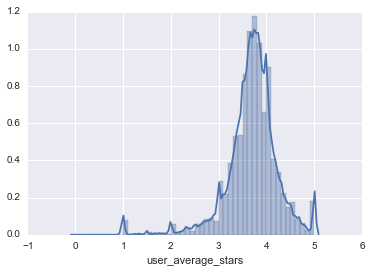

In [118]:
sns.distplot(trust.user_average_stars)
trust.user_average_stars.head()

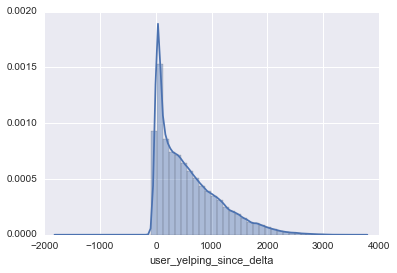

In [132]:
sns.distplot(trust.user_yelping_since_delta)
# sns.distplot(trust.user_yelping_since_delta.apply(np.log).fillna(0))

In [142]:
trust.shape

(500936, 10)

score_lvl_3 ~ subjectivity + review_votes_cool + review_votes_funny + review_votes_useful + user_average_stars + user_review_count + user_yelping_since_delta + user_ever_elite


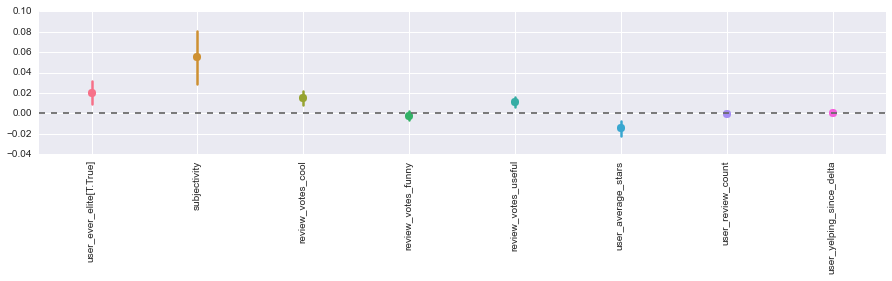

In [178]:
data = pd.merge(df[['inspection_id', 'enumerated_review_delta', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']], trust, on=['inspection_id', 'enumerated_review_delta'])
atts = ['subjectivity',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
 'user_review_count',
 'user_yelping_since_delta',
 'user_ever_elite'
       ]
formula = "score_lvl_3 ~ " + ' + '.join([i for i in atts])
print formula
sns.coefplot(formula, data, intercept=False)
plt.xticks(rotation=90)
plt.tight_layout()

## anger index. how often they post compared to how negative the reviews are

## pivot reviews out

In [16]:
combo.set_index(['inspection_id', 'enumerated_review_delta'])

polarity  subjectivity    neg    neu  \
inspection_id enumerated_review_delta                                         
0             0                        0.222946      0.713393  0.000  0.783   
              1                        0.237602      0.495938  0.008  0.839   
1             0                        0.189981      0.518578  0.000  0.853   
              1                        0.115152      0.507576  0.030  0.776   
              2                        0.324259      0.577407  0.000  0.686   
2             0                        0.005025      0.618128  0.054  0.759   
              1                       -0.234226      0.630952  0.152  0.790   
              2                        0.700000      0.600000  0.000  0.562   
              3                        0.158102      0.462963  0.134  0.585   
              4                        0.019551      0.700549  0.044  0.802   
              5                        0.255694      0.596889  0.124  0.639   
              6                        0.250000      0.556061  0.000  0.819   
              7                        0.343308      0.525440  0.033  0.876   
              8                        0.173016      0.525317  0.061  0.831   
7             0                        0.193750      0.417708  0.027  0.903   
8             0                        0.214286      0.764286  0.000  0.626   
              1                       -0.059524      0.469048  0.080  0.836   
              2                        0.166833      0.502667  0.117  0.651   
              3                        0.030000      0.185000  0.000  1.000   
              4                        0.259574      0.605970  0.021  0.742   
              5                        0.500000      1.000000  0.000  0.428   
9             0                       -0.225000      0.658333  0.145  0.814   
              1                       -0.156003      0.483920  0.115  0.801   
              2                        0.171605      0.551757  0.139  0.619   
10            0                       -0.300000      0.475000  0.000  1.000   
              1                        0.021298      0.526568  0.064  0.812   
              2                        0.164500      0.768000  0.033  0.777   
              3                        0.069048      0.442857  0.077  0.804   
              4                        0.247436      0.401979  0.030  0.829   
12            0                        0.070000      0.760000  0.140  0.652   
...                                         ...           ...    ...    ...   
33858         2                        0.039653      0.519749  0.034  0.845   
              3                        0.171218      0.489566  0.058  0.743   
              4                        0.234091      0.518182  0.079  0.748   
              5                        0.396667      0.766667  0.000  0.797   
              6                        0.365367      0.618171  0.033  0.699   
              7                        0.487500      0.643750  0.039  0.794   
              8                        0.602000      0.776000  0.000  0.506   
              9                        0.427273      0.604545  0.000  0.737   
              10                       0.300000      0.300000  0.000  0.756   
              11                       0.324500      0.608000  0.000  0.756   
              12                       0.426587      0.579206  0.029  0.618   
              13                       0.113542      0.489583  0.050  0.733   
              14                      -0.500000      0.500000  0.268  0.732   
              15                       0.334000      0.764000  0.000  0.578   
              16                       0.495185      0.674352  0.059  0.613   
              17                       0.208820      0.539719  0.027  0.796   
              18                       0.200000      0.300000  0.000  1.000   
              19                       0.594444      0.813889  0.000  0.665   
          

In [47]:
combo.pivot(index='inspection_id', columns='enumerated_review_delta')
# combo.set_index(['inspection_id', 'enumerated_review_delta']).unstack(1)
# combo.pivot_table(index='inspection_id', columns='enumerated_review_delta')
# df.groupby('inspection_id').max()

polarity                                          \
enumerated_review_delta       0         1         2         3         4     
inspection_id                                                               
0                        0.222946  0.237602       NaN       NaN       NaN   
1                        0.189981  0.115152  0.324259       NaN       NaN   
2                        0.005025 -0.234226  0.700000  0.158102  0.019551   
7                        0.193750       NaN       NaN       NaN       NaN   
8                        0.214286 -0.059524  0.166833  0.030000  0.259574   
9                       -0.225000 -0.156003  0.171605       NaN       NaN   
10                      -0.300000  0.021298  0.164500  0.069048  0.247436   
12                       0.070000  0.016346 -0.222222  0.600000       NaN   
13                       0.196212  0.156618  0.187500  0.422240  0.268182   
14                      -0.059730 -0.283333 -0.208333  0.125757 -0.109040   
15                       0.033333 -0.225556  0.325694 -0.036000  0.112923   
16                       0.533333       NaN       NaN       NaN       NaN   
17                       0.034028  0.294792  0.198214 -0.005556 -0.113500   
18                       0.300000  0.202500  0.370000  0.519048  0.328114   
19                       0.000000  0.417308  0.192949  0.036667  0.320312   
23                       0.131349 -0.103000  0.198947  0.196883  0.343750   
24                       0.450000  0.287292  1.000000  0.098106  0.000000   
27                       0.137415  0.300735  0.135119  0.387500  0.115625   
28                       0.152106  0.102381 -0.450000  0.341165  0.236556   
29                       0.218202  0.212468  0.296484  0.310900  0.157185   
30                       0.104861  0.147377       NaN       NaN       NaN   
32                       0.244273  0.190606  0.800000  0.416667  0.082930   
33                       0.083333  0.101017  0.158102  0.116667  0.340000   
34                       0.206389  0.283333  0.018056  0.131371  0.077425   
36                       0.183333 -0.044097       NaN       NaN       NaN   
37                       0.643333  0.116017  0.211640 -0.380000  0.447917   
38                       0.800000  0.090646  0.260937  0.230303       NaN   
40                       0.353802  0.183333  0.202841  0.150641  0.575000   
42                      -0.068750  0.159470  0.109664  0.262235  0.508333   
43                      -0.015119  0.000000 -0.206746  0.098958  0.119271   
...                           ...       ...       ...       ...       ...   
33819                    0.000000  0.625000  0.219786  0.000000 -0.098073   
33820                    0.181000 -0.278704  0.250000  0.269038  0.432500   
33821                    0.090000  0.375000 -0.135779  0.000000 -0.500000   
33822                    0.644271  0.166760  0.625000  0.000000  0.230511   
33824                    0.262500  0.316964  0.375465  0.015404  0.485268   
33825                    0.307353  0.406944       NaN       NaN       NaN   
33826                    0.104040  0.475000  0.003139  0.121429       NaN   
33827                    0.350000       NaN       NaN       NaN       NaN   
33828                    0.223148  0.166667  0.115000  0.131944  0.488889   
33829                    0.471429  0.230556  0.183333       NaN       NaN   
33830                   -0.453333  0.054565  0.136905  0.039062 -0.325758   
33831                    0.141667 -0.050000 -0.042308  0.500000  0.255602   
33834                    0.113194  0.129583  0.273611  0.356548       NaN   
33835                    0.062847  0.036813  0.400000  0.065476  0.174167   
33836                    0.347222  0.050000 -0.015278       NaN       NaN   
33837                   -0.234524 -0.247976  0.309425  0.067708  0.000000   
33838                    0.023203  0.001683  0.014660  0.155268  0.117710   
33839                   -0.409375  0.276786  0.058333       NaN       NaN   
33842                

In [10]:
pol_temp.pivot('inspection_id', 'enumerated_review_delta').polarity.head()

enumerated_review_delta,0,1,2,3,4,5,6,7,8,9,...,435,436,437,438,439,440,441,442,443,444
inspection_id,,,,,,,,,,,,,,,,,,,,,
0,0.222946,0.237602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.189981,0.115152,0.324259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.005025,-0.234226,0.700000,0.158102,0.019551,0.255694,0.25,0.343308,0.173016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.193750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.214286,-0.059524,0.166833,0.030000,0.259574,0.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['review_stars'] = df.review_stars.fillna(0).astype('category')
df.restaurant_attributes_price_range = df.restaurant_attributes_price_range.fillna(df.restaurant_attributes_price_range.median())

In [87]:
from sklearn.decomposition import PCA, TruncatedSVD

def pivot_feature(df, feature, limit=None, decomp='lsa', decomp_features=100, fill='median'):
    # make the large dataframe faster to handle on pivot
    temp = df[['inspection_id', 'enumerated_review_delta'] + [feature]]
    
    # pivot so that each inspection id only has one observation with each review a feature for that observation
    pivoted_feature = temp.pivot('inspection_id', 'enumerated_review_delta')[feature]
    
              
    # pivoting creates a number of empty variables when they have less than the max number of reviews        
    if fill == 'median':
        fill_empties = lambda x: x.fillna(x.median())
    elif fill == 'mean':
        fill_empties = lambda x: x.fillna(x.mean())
    elif fill == 0:
        fill_empties = lambda x: x.fillna(0)
    elif fill == 'inter':
        fill_empties = lambda x: x.interpolate()
    else:
        raise Exception
    
    pivoted_feature = pivoted_feature.apply(fill_empties, axis=1)
              
    if decomp == 'lsa':
        decomposition = TruncatedSVD(decomp_features)
    elif decomp == 'pca':
        decomposition = PCA(decomp_features)
    elif decomp == None:
        pass
    else:
        raise Exception
    
    if not limit:
        try:
            return decomposition.fit_transform(pivoted_feature)
        except:
            return pivoted_feature
    else:
        try:
            return decomposition.fit_transform(pivoted_feature)[: , 0:limit]
        except:
            return pivoted_feature[[i for i in range(limit)]]

In [12]:
tfidf = joblib.load('pickle_jar/tfidf_preprocessed_ngram3_sublinear_1mil_pivot_365')

from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(100)
lsa_tfidf = lsa.fit_transform(tfidf)
tfidf_pivot = pd.concat([combo[['inspection_id', 'enumerated_review_delta']], pd.DataFrame(lsa_tfidf)], axis=1)

<500936x1000000 sparse matrix of type '<type 'numpy.float64'>'
	with 55926334 stored elements in Compressed Sparse Row format>

In [207]:
# combo[['inspection_id', 'enumerated_review_delta', 'manager']].pivot('inspection_id', 'enumerated_review_delta')
def test(x):
    try:
        return x[0]
    except:
        return x

combo['t1'] = combo.drip.apply(test)
combo['t2'] = combo.manager.apply(test)
combo['t3'] = combo.violation.apply(test)

In [208]:
X = pivot_feature(combo, feature='t1', limit=5, decomp=None)
y = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]

In [198]:
# combine two features
X2 = pivot_feature(combo, feature='t1', limit=5, decomp=None)
X3 = pivot_feature(combo, feature='t3', limit=5, decomp=None)
X = np.hstack((X, X2, X3))

In [199]:
# combine tfidf with other features
X = np.hstack((X, tfidf_pivot.groupby('inspection_id').mean(), df[['inspection_month']]))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MinMaxScaler

t0 = time()


estimator_list = [
#     LinearRegression(), 
#     SGDClassifier(n_jobs=-1, random_state=42), 
#     Perceptron(n_jobs=-1, random_state=42),  # gets some nuances
    SGDRegressor(), # gets some nuances
    RandomForestClassifier(n_jobs=-1, random_state=42), 
    RandomForestRegressor(n_jobs=-1, random_state=42),
#     KNeighborsClassifier(),
#     KNeighborsRegressor(),  # gets some nuances
# DecisionTreeClassifier(),
# DecisionTreeRegressor(),
# GaussianNB(),
# MultinomialNB(),
# LinearSVC(random_state=42),
]

for estimator in estimator_list:
    pipeline = Pipeline([
#         ('zero_variance_removal', VarianceThreshold()),
#         ('k_best', SelectKBest(score_func=f_classif, k=20)),
#         ('no_negative', MinMaxScaler()),
#         ('normalizer', Normalizer(norm='l2')), #  for text classification and clustering
#         ('normalizer', Normalizer(copy=False)),
#         ('scaler', StandardScaler()),
#         ('scaler', StandardScaler(with_mean=False)), #  for sparse matrix
        ('clf', estimator),
])
    print estimator
#     for i in range(1,11):
#         print(i)
#         X = pivot_feature(combo, feature='polarity', limit=i, decomp=None)
#         p1,p2,p3,ytest = raw_fit(X, y, pipeline)
#         raw_scoring(p1,p2,p3,ytest)
    p1,p2,p3,ytest = raw_fit(X, y, pipeline)
    raw_scoring(p1,p2,p3,ytest)
    print('\n')


print("{} seconds elapsed".format(time()-t0))

# first similarity vector for drip rf
# Level 1 accuracy score of 0.305500982318
# Level 2 accuracy score of 0.749345121153
# Level 3 accuracy score of 0.607891290111
# Contest score of 1.41595776238


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)
Level 1 accuracy score of 0.321877445422
Level 2 accuracy score of 0.700193238258
Level 3 accuracy score of 0.570947186866
Contest score of 1.38332328149


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
Level 1 accuracy score of 0.0954533114011

In [152]:
# baseline scores if guessing zero
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
guess = 0
for index, score in enumerate(scores):
    print("level {}: {}".format(index+1, y[score].value_counts(normalize=True)[guess]))

NameError: name 'y' is not defined